In [1]:
import warnings
warnings.filterwarnings("ignore")
from ipypublish.scripts.ipynb_latex_setup import *
from IPython.display import display, Image, IFrame
import pymatgen as pym
import ipywidgets as widgets
import ipyvolume as ivol
import ipyvolume.pylab as p3
from jsonextended import edict, plugins
errors = plugins.load_builtin_plugins()
import atom_visual as avis
import jsonplugins as jplugins

//anaconda/envs/lsr/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
//anaconda/envs/lsr/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


[]


In [2]:
my_data = edict.LazyLoad('data/')

# Introduction

With the improvements in Jupyter Notebook, allowing for the synergy of browser-side javascript and client-side python coding, it is becoming possible to replicate the functionality of standalone atomic visualisation packages (such as [ovito](https://ovito.org/index.php/about)). The added benefits this approach brings is:

- Greater control and flexibility in the analysis and visualisation process 
- Fully autonomous replication of the analysis and visualisation
- Better documentation of the analysis and visualisation

The goal of this notebook is to show a method for:

1. reading/creating atomic configurations
2. visualising these in a Jupyter Notebook
3. Adding dynamic controls 
4. Overlaying electronic level data (probability/spin densities)
5. Distributing the output

The code for this demonstration can be found at...

# A Quick Introduction to JSON

Many atomic analysis packages specify their 

```python
from package import Crystal
crystal = Crystal('Fe','bcc',a=2.5)
cell = crystal.cell
coords = crystal.coords
...
```

Obscures the actual data

Benefits of JSON format over proprietary data structure:

- easy to view/understand
- extensible. 

[jsonextended](https://github.com/chrisjsewell/jsonextended), which is a package for parsing file types into a json format and subsequent manipulation

In [30]:
from jsonextended import edict, plugins
plugins.load_builtin_plugins()
here = edict.LazyLoad('')
here

{3D Atomic Visualisation.ipynb:..,Test.ipynb:..,converted:..,data:..}

In [31]:
idict = here.i3D_Atomic_Visualisation_ipynb.to_dict()
edict.pprint(idict,
        depth=1,no_values=False)

cells:          [...]
metadata:       {...}
nbformat:       4
nbformat_minor: 2


Instead of asserting object types and data structure up front.. this is in keeping withing the interpreted (as opposed to declarative) nature of Python.

- https://spacetelescope.github.io/understanding-json-schema/basics.html
- http://forivall.com/json-schema-cheatsheet/
- https://lat.sk/2017/03/custom-json-schema-type-validator-format-python
- https://github.com/MolSSI/QC_JSON_Schema

In [32]:
from jsonschema import validate
cells_schema = {
    'type':'array',
    'items':{
      'type':'object',
      'required':['cell_type'],
      'properties':{
        'cell_type':{
         'type':'string',
         'enum':["code","markdown"]
    }}}}
schema = {'type':'object',
          'required':['cells','metadata'],
          'properties':{'cells':cells_schema}}
validate(idict, schema)

In [33]:
try:
    validate({'metadata':{},
              'cells':[{'cell_type':'a'}]}, 
             schema)
except Exception as err:
    print(err)

'a' is not one of ['code', 'markdown']

Failed validating 'enum' in schema['properties']['cells']['items']['properties']['cell_type']:
    {'enum': ['code', 'markdown'], 'type': 'string'}

On instance['cells'][0]['cell_type']:
    'a'


# Creating Atomic Configurations

The [pymatgen](http://pymatgen.org/) package offers a means to create/manipulate atomic configurations with repeating boundary conditions. 

For this demonstration, we would like to select structures from a folder of cif (crystallographic information files). This is achieved by writing a *plugin* for [jsonextended](https://github.com/chrisjsewell/jsonextended).

In [7]:
from jsonplugins import CIFPlugin
plugins.load_plugin_classes([CIFPlugin],'parsers')
edict.pprint(my_data.cif_files, depth=1)

FeS_greigite.cif: {...}
FeS_mackinawite.cif: {...}
FeS_marcasite.cif: {...}
FeS_pyrite.cif: {...}
FeS_pyrrhotite_4C_c2c.cif: {...}
FeS_troilite.cif: {...}
Fe_bcc.cif: {...}
S_8alpha_fddd.cif: {...}
S_8beta_p21c.cif: {...}


For each cif, we can now access a pymatgen structure:

In [8]:
pymstruct = my_data.cif_files.Fe_bcc_cif.structure
pymstruct

Structure Summary
Lattice
    abc : 2.4820288072462011 2.4820288072462011 2.4820288072462011
 angles : 109.47122063449069 109.47122063449069 109.47122063449069
 volume : 11.770598948
      A : -1.4329999999999996 -1.4330000000000001 1.4329999999999998
      B : -1.4330000000000001 1.4330000000000001 -1.4330000000000001
      C : 1.4330000000000001 -1.4330000000000001 -1.4330000000000001
PeriodicSite: Fe (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]

Note that the underlying structure of the pymatgen structure is a json.

In [9]:
edict.pprint(pymstruct.as_dict(),depth=None,
             round_floats=3,max_width=40,
             keycolor='blue')

@class: Structure
@module: pymatgen.core.structure
lattice: 
  a: 2.48
  alpha: 109.0
  b: 2.48
  beta: 109.0
  c: 2.48
  gamma: 109.0
  matrix: [[-1.43, -1.43, 1.43], [-1.43, 
          1.43, -1.43], [1.43, -1.43, 
          -1.43]]
  volume: 11.8
sites: 
  - abc: [0.0, 0.0, 0.0]
    label: Fe
    species: 
      - element: Fe
        occu: 1
    xyz: [0.0, 0.0, 0.0]


# Preparation for visualisation

A visualisation requires the configuration to contain some additional information, 
including the atom shape (e.g. sphere radius) and texture (e.g. sphere color).

Therefore, it will be helpful to create a view agnostic (i.e. independendant of any specific graphics package) representation of all elements we wish to visualise. We do this by deconstructing the pymatgen structure and applying a mapping of atomic number to radius/color, using a pre-constructed csv table.

In [10]:
amap = avis.get_atom_map()
amap.head().round(2).drop(['MaxBnd','ARENeg'],axis=1)

,Blue,ElAffinity,ElNeg,Green,Ionization,Mass,Name,RBO,RCov,RVdW,Red,Symbol
atomic number,,,,,,,,,,,,
1,0.75,0.75,2.20,0.75,13.60,1.01,Hydrogen,0.31,0.31,1.10,0.75,H
2,1.00,0.00,0.00,1.00,24.59,4.00,Helium,0.28,0.28,1.40,0.85,He
3,1.00,0.62,0.98,0.50,5.39,6.94,Lithium,1.28,1.28,1.81,0.80,Li
4,0.00,0.00,1.57,1.00,9.32,9.01,Beryllium,0.96,0.96,1.53,0.76,Be
5,0.71,0.28,2.04,0.71,8.30,10.81,Boron,0.84,0.84,1.92,1.00,B


In [11]:
def new_struct_to_visual(struct,name,atom_map=None):
    if atom_map is None:
        atom_map = default_atom_map
    color = 'rgb({r},{g},{b})'
    a,b,c = [_ for _ in struct.lattice.matrix]
    centre = 0.5*(a+b+c)
    
    sdict = {}
    for anum, pos in zip(struct.atomic_numbers,struct.cart_coords):
        key = atom_map.loc[anum].Symbol
        if key not in sdict:
            sdict[key] = {}
            sdict[key]['type'] = 'repeat_cell'
            sdict[key]['sname'] = name                        
            sdict[key]['label'] = atom_map.loc[anum].Symbol            
            sdict[key]['radius'] = atom_map.loc[anum].RCov    
            sdict[key]['transparency'] = 1.0
            sdict[key]['color'] = color.format(r=int(float(atom_map.loc[anum].Red)*255),
                                          g=int(float(atom_map.loc[anum].Green)*255),
                                          b=int(float(atom_map.loc[anum].Blue)*255))
            sdict[key]['centre'] = centre.tolist()
            sdict[key]['cell_vectors'] = {}
            sdict[key]['cell_vectors']['a'] = a.tolist()
            sdict[key]['cell_vectors']['b'] = b.tolist()
            sdict[key]['cell_vectors']['c'] = c.tolist()
            sdict[key]['coords'] = []
            sdict[key]['visible'] = []
            sdict[key]['transforms'] = []
            
        sdict[key]['coords'].append(pos.tolist())
        sdict[key]['visible'].append(True)
    
    return {'repeat_cells':list(sdict.values())}           

In [12]:
struct = my_data.cif_files.FeS_mackinawite_cif.structure
vstructs = avis.struct_to_visual(struct,'mackinawite')
edict.pprint(vstructs,
    max_width=67,keycolor='blue',round_floats=3)

mackinawite_Fe: 
  cell_vectors: 
    a: [ 3.67350000e+00 0.00000000e+00 2.24937001e-16]
    b: [ -2.24937001e-16 3.67350000e+00 2.24937001e-16]
    c: [ 0. 0. 5.0328]
  centre: [ 1.83675 1.83675 2.5164 ]
  color: rgb(224,102,51)
  coords: [[ 0. 0. 0.], [ 1.83675000e+00 1.83675000e+00 
          2.24937001e-16]]
  label: Fe
  radius: 1.32
  transparency: 1.0
  type: scatter
  visible: [True, True]
mackinawite_S: 
  cell_vectors: 
    a: [ 3.67350000e+00 0.00000000e+00 2.24937001e-16]
    b: [ -2.24937001e-16 3.67350000e+00 2.24937001e-16]
    c: [ 0. 0. 5.0328]
  centre: [ 1.83675 1.83675 2.5164 ]
  color: rgb(178,178,0)
  coords: [[ -1.12468500e-16 1.83675000e+00 1.30953456e+00], [ 
          1.83675 0. 3.72326544]]
  label: S
  radius: 1.05
  transparency: 1.0
  type: scatter
  visible: [True, True]


Note that we group atoms with the same visual representations, rather than specifying each atom separately. This is because it will be more efficient for the rendering process (see [here](http://www.ianww.com/blog/2012/11/04/optimizing-three-dot-js-performance-simulating-tens-of-thousands-of-independent-moving-objects/) for an explanation). Here we do this by atomic number, but equally it could be done by symmetry equivalence or another metric.

## Geometry Manipulation

We will also likely want to:

- create a supercell of the configuration 
- orientate the configuration in a convenient manner in the cartesian coordinate space
- slice into the configuration

We can group these operations into a class, which is extensible to more geometric operation and element types.

In [13]:
struct = my_data.cif_files.FeS_mackinawite_cif.structure
vstructs = avis.struct_to_visual(struct,'mackinawite')

geomanip = avis.GeometryManipulation()
geomanip.align(vstructs,'b')
geomanip.repeat_cell(vstructs,'a',2)
geomanip.repeat_cell(vstructs,'b',2)
geomanip.repeat_cell(vstructs,'c',2)
geomanip.recentre(vstructs)
geomanip.cslice(vstructs,(0,0,1),ubound=1.)

edict.pprint(vstructs,max_width=67,
             compress_lists=1,keycolor='blue')

mackinawite_Fe: 
  cell_vectors: 
    a: [ -6.74811003e-16 -1.10205000e+01 -1.47911420e-31]
    b: [ 1.10205000e+01 -4.13202567e-32 -1.47911420e-31]
    c: [ 9.24510362e-16 -9.24510362e-16 1.50984000e+01]
  centre: [ 0. 0. 0.]
  color: rgb(224,102,51)
  coords: [[-5.51025 5.51025 -7.5492 ], ...(x53)]
  label: Fe
  radius: 1.32
  transparency: 1.0
  type: scatter
  visible: [True, ...(x53)]
mackinawite_S: 
  cell_vectors: 
    a: [ -6.74811003e-16 -1.10205000e+01 -1.47911420e-31]
    b: [ 1.10205000e+01 -4.13202567e-32 -1.47911420e-31]
    c: [ 9.24510362e-16 -9.24510362e-16 1.50984000e+01]
  centre: [ 0. 0. 0.]
  color: rgb(178,178,0)
  coords: [[-3.6735 5.51025 -6.23966544], ...(x53)]
  label: S
  radius: 1.05
  transparency: 1.0
  type: scatter
  visible: [True, ...(x53)]


# Visualising in the Jupyter Notebook

To create 3D renderings of the configuration, we will use [ipyvolume](http://ipyvolume.readthedocs.io) and its implementation of the model/view pattern.

In [ ]:
def create_ivol(vstructs,
                width=500,height=400):
    p3.clear()
    fig = p3.figure(width=width,height=height,controls=True)
    fig.screen_capture_enabled = True
    
    for vstruct in vstructs.values():
        if vstruct['type'] == 'scatter':    
            coords = np.array(vstruct['coords'])[vstruct['visible']]
            x, y, z = coords.T
            s = p3.scatter(x,y,z,marker='sphere',size=6,color=vstruct['color'])        
            vstruct['ivol'] = s
    
    # split up controls
    figbox, fullscreen = p3.gcc().children
    
    return fig, {'view':[fullscreen]}

In [14]:
vstructs = avis.struct_to_visual(struct,'mackinawite')
geomanip = avis.GeometryManipulation()
geomanip.align(vstructs,'b')
geomanip.repeat_cell(vstructs,'a',3)
geomanip.repeat_cell(vstructs,'b',3)
geomanip.repeat_cell(vstructs,'c',3)
geomanip.recentre(vstructs,(0.0, 0.0, 0.0))
geomanip.cslice(vstructs,(0,0,1),ubound=-4)

fig, controls1 = avis.create_ivol(vstructs)
#fig.anglex = np.radians(90) # has to be used after instantiation
gui = widgets.VBox([fig,controls1['view'][0]])
gui

A Jupyter Widget

The rendering can also be captured as a screenshot or saved as an image/html. We shall discuss in [a later section](#Analysis-Distribution) how this can be utilised for to distribute the analysis.

In [42]:
image = p3.screenshot(width=500, height=500)
ivol.embed.embed_html('data/ivol_example1.html',[gui],
        template_options={"embed_url":'embed.js'})

A Jupyter Widget

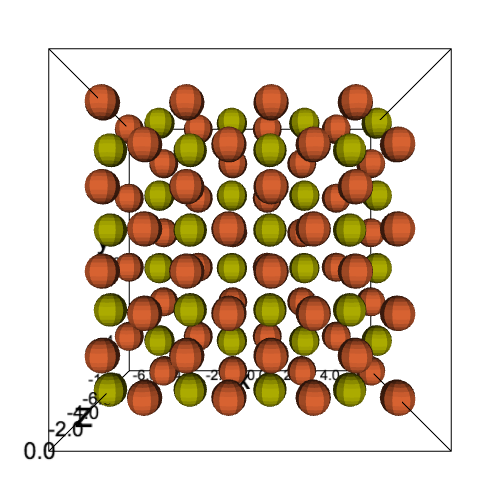

In [17]:
display(image,metadata={'ipub':{'embed_html':{
    "filepath":'data/ivol_example1.html',
    "other_files":["data/embed.js","data/ipyvolume.js"]}}})

# Adding Dynamic Controls

[ipyvolume](http://ipyvolume.readthedocs.io) utilises the [ipywidgets](http://ipywidgets.readthedocs.io) framework and thus it is relatively trivial to set up dynamic controls.

In [15]:
cntrl = avis.create_ivol_control(vstructs['mackinawite_Fe'],'size',
                    'FloatSlider','value',min=0,max=10,
                    description='Fe Size')
cntrl

A Jupyter Widget

We can bundle these in with the original container to create a bespoke GUI.

In [16]:
cntrls = controls1
for name, vstruct in vstructs.items():
    cntrl1 = avis.create_ivol_control(vstruct,'size',
                        'FloatSlider','value',min=0,max=10,
                        description='Size')
    cntrl2 = avis.create_ivol_control(vstruct,'color',
                        'ColorPicker','value',
                        description='Color')
    cntrls[name.replace('_',' ')] = [cntrl1,cntrl2]
    
new_gui = avis.add_controls(fig,cntrls,top=True) 
new_gui

A Jupyter Widget

In [41]:
image2 = p3.screenshot(width=500, height=500)
ivol.embed.embed_html('data/ivol_example2.html',
    [new_gui],template_options={"embed_url":'embed.js'})

A Jupyter Widget

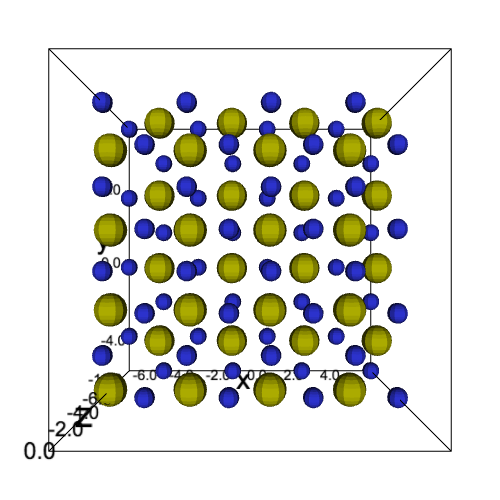

In [24]:
display(image2,metadata={'ipub':{'embed_html':{
    "filepath":'data/ivol_example2.html',
    "other_files":["data/embed.js","data/ipyvolume.js"],
     "height":0.45}}})

# Overlaying electronic level data

*Ab initio* quantum simulation packages can compute electronic/spin densities (to accompany the nuclei positions) in the form of a discretized 3D cube. These can be overlayed onto the nuclei, by [volume rendering](https://en.wikipedia.org/wiki/Volume_rendering) or [isosurface](https://en.wikipedia.org/wiki/Isosurface) methods. 

## Data Parsing

Taking the [CRYSTAL](http://www.crystal.unito.it/index.php) program as an example, output from the electronic density is principally output into two files; one that contains the lattice vectors and nuclei coordinates and one that contains a data cube of the electronic density, with axis relating to the cell vectors. We can write parser plugins for both these files:

In [3]:
plugins.load_plugin_classes([jplugins.ECH3OutPlugin,jplugins.ECH3CubePlugin],'parsers')
edict.pprint(my_data.crystal,keycolor='blue')

ech3.out: 
  structure: Full Formula (Si2)
             Reduced Formula: Si
             abc   :   3.832519   3.832519   3.832519
             angles:  60.000000  60.000000  60.000000
             Sites (2)
               #  SP           a         b         c
             ---  ----  --------  --------  --------
               0  Si    0.125092  0.125092  0.125092
               1  Si    0.874908  0.875277  0.874908
ech3_dat.prop3d: 
  charge_density: np.array((100, 100, 100), min=2.68E-03, max=5.36E+02)
  da_vec: [ 0. 0.051729 0.051729]
  db_vec: [ 0.051729 0. 0.051729]
  dc_vec: [ 0.051729 0.051729 0. ]
  na:    100
  nb:    100
  nc:    100
  o_vec: [0.0, 0.0, 0.0]


## Visualisation Preparation

We then, follow the same process as for atoms; converting to a common structure and adding geometric manipulation functions for this data type.

In [4]:
nuclei = avis.struct_to_visual(my_data.crystal.ech3_out['structure'],'Silicon')
electrons = avis.dcube_to_visual(my_data.crystal.ech3_dat_prop3d['charge_density'],
                            my_data.crystal.ech3_out['structure'],
                            'Silicon Charge')
dstructs = edict.merge([nuclei,electrons])
edict.pprint(dstructs,keycolor="blue")

Silicon Charge: 
  cell_vectors: 
    a: [ 0. 2.71 2.71]
    b: [ 2.71 0. 2.71]
    c: [ 2.71 2.71 0. ]
  centre: [ 2.71 2.71 2.71]
  dcube: np.array((100, 100, 100), min=2.68E-03, max=5.36E+02)
  slices: []
  type: volume
Silicon_Si: 
  cell_vectors: 
    a: [ 0. 2.71 2.71]
    b: [ 2.71 0. 2.71]
    c: [ 2.71 2.71 0. ]
  centre: [ 2.71 2.71 2.71]
  color: rgb(127,153,153)
  coords: [[ 0.678 0.678 0.678], [ 4.743 4.742 4.743]]
  label: Si
  radius: 1.11
  transparency: 1.0
  type: scatter
  visible: [True, True]


In [29]:
def repeat_cell_volume(vstruct,vector='a',rep=1,
                newcentre=True):    
    assert vstruct['type'] == 'volume'
    reps = OrderedDict([('a',1),('b',1),('c',1)])
    reps[vector] += abs(rep)
    vstruct['dcube'] = np.tile(vstruct['dcube'],
                               list(reps.values()))
    
    repv = vstruct['cell_vectors'][vector]
    vstruct['cell_vectors'][vector] = repv * (abs(rep)+1)
    
    if newcentre:
        vstruct['centre'] = 0.5*(vstruct['cell_vectors']['a']
                                +vstruct['cell_vectors']['b']
                                +vstruct['cell_vectors']['c'])

def recentre_volume(vstruct,centre=(0.,0.,0.)):
    assert vstruct['type'] == 'volume'
    vstruct['centre'] = np.asarray(centre,dtype=float)   

def align_volume(vstruct,vector='a',direction=(1,0,0)):
    """align cell vector to a cartesian direction"""
    assert vstruct['type'] == 'volume'
    direction=np.asarray(direction,dtype=float)
    v = vstruct['cell_vectors'][vector]
    new_cell = _realign_vectors([vstruct['cell_vectors']['a'],
                                 vstruct['cell_vectors']['b'],
                                 vstruct['cell_vectors']['c']],
                                 v,direction)
    vstruct['cell_vectors']['a'] = new_cell[0]
    vstruct['cell_vectors']['b'] = new_cell[1]
    vstruct['cell_vectors']['c'] = new_cell[2]

def cslice_volume(vstruct,normal=(1,0,0),lbound=None,ubound=None,
          centre=None):
    assert vstruct['type'] == 'volume'
    normal=np.asarray(normal,dtype=float)
    vstruct['slices'].append((
        normal,lbound,ubound,centre)) 

class NewGeometryManipulation(GeometryManipulation):
    _manip_dict = {
        'scatter':{'repeat_cell':repeat_cell_scatter,
                   'recentre':recentre_scatter,
                   'align':align_scatter,
                   'cslice':cslice_scatter},
        'volume':{'repeat_cell':repeat_cell_volume,
                   'recentre':recentre_volume,
                   'align':align_volume,
                   'cslice':cslice_volume}
    }
    def align(self,*args,**kwargs):
        raise NotImplementedError(
            'rotating cell vectors currently not working for volumes')

In [5]:
nuclei = avis.struct_to_visual(my_data.crystal.ech3_out['structure'],'Silicon')
electrons = avis.dcube_to_visual(my_data.crystal.ech3_dat_prop3d['charge_density'],
                            my_data.crystal.ech3_out['structure'],
                            'Silicon Charge')
dstructs = edict.merge([nuclei,electrons])
geomanip = avis.GeometryManipulationWithVol()
#geomanip.align(dstructs,'b')
geomanip.repeat_cell(dstructs,'a',3)
geomanip.repeat_cell(dstructs,'b',3)
geomanip.repeat_cell(dstructs,'c',3)
geomanip.recentre(dstructs,(0.0, 0.0, 0.0))
geomanip.cslice(dstructs,(0,0,1),ubound=-4)
edict.pprint(dstructs,keycolor='blue',compress_lists=1)

Silicon Charge: 
  cell_vectors: 
    a: [ 0. 10.84 10.84]
    b: [ 10.84 0. 10.84]
    c: [ 10.84 10.84 0. ]
  centre: [ 0. 0. 0.]
  dcube: np.array((400, 400, 400), min=2.68E-03, max=5.36E+02)
  slices: [([ 0. 0. 1.], ...(x3))]
  type: volume
Silicon_Si: 
  cell_vectors: 
    a: [ 0. 10.84 10.84]
    b: [ 10.84 0. 10.84]
    c: [ 10.84 10.84 0. ]
  centre: [ 0. 0. 0.]
  color: rgb(127,153,153)
  coords: [[-10.162 -10.162 -10.162], ...(x127)]
  label: Si
  radius: 1.11
  transparency: 1.0
  type: scatter
  visible: [True, ...(x127)]


## Visualisation

For ipyvolume, at present, the volume data must a cube of equal dimensions. 
Therefore, we use the cell vectors to transform the data cube into cartesian coordinates,
such that voxels (cube sections) outside of the cell volume are set as np.nan values.
We also resize the discretisation of the cube to an appropriate size for the renderer to handle. 

Additionally, for ipyvolume (in its current state), there can only be one volume rendering per scene and it is assumed that the volumes bottom left corner is at (0,0,0).

In [11]:
nuclei = avis.struct_to_visual(my_data.crystal.ech3_out['structure'],'Silicon')
electrons = avis.dcube_to_visual(my_data.crystal.ech3_dat_prop3d['charge_density'],
                            my_data.crystal.ech3_out['structure'],
                            'Silicon Charge')
dstructs = edict.merge([nuclei,electrons])
geomanip = avis.GeometryManipulationWithVol()
#geomanip.align(dstructs,'b')
geomanip.repeat_cell(dstructs,'a',3)
geomanip.repeat_cell(dstructs,'b',3)
geomanip.repeat_cell(dstructs,'c',3)
geomanip.recentre(dstructs,(0.0, 0.0, 0.0))
geomanip.cslice(dstructs,(0,1,1),lbound=-2,ubound=0)

edict.pprint(dstructs['Silicon Charge'])

cell_vectors: 
  a: [ 0. 10.84 10.84]
  b: [ 10.84 0. 10.84]
  c: [ 10.84 10.84 0. ]
centre: [ 0. 0. 0.]
dcube:  np.array((400, 400, 400), min=2.68E-03, max=5.36E+02)
slices: [([ 0. 1. 1.], -2, 0, None)]
type:   volume


In [12]:
fig, controls = avis.create_ivol_withvol(dstructs,data_min=1.6,data_max=2,
                            level=[.5, .25, .1],opacity=[.2,.15,.05])
cntrl = avis.create_ivol_control(
    dstructs['Silicon_Si'],'size',
    'FloatSlider','value',
     min=0, max=10,
     description='Size')
controls['Nucleii'] = [cntrl]
volgui = avis.add_controls(fig,controls)
volgui

A Jupyter Widget

In [38]:
image3 = p3.screenshot(width=500, height=500)
ivol.embed.embed_html('data/ivol_example3.html',
[volgui],template_options={"embed_url":'embed.js'})

A Jupyter Widget

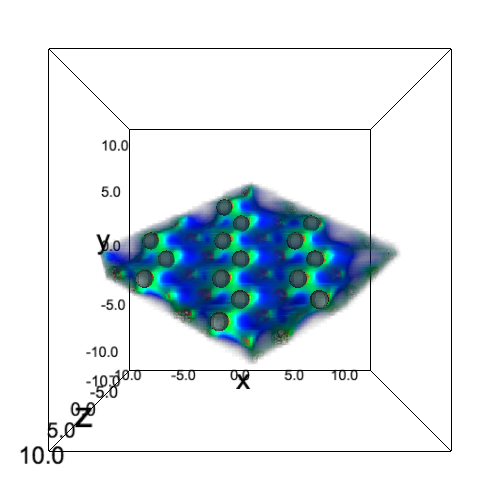

In [39]:
display(image3,metadata={'ipub':{'embed_html':{
    "filepath":'data/ivol_example3.html',
    "other_files":["data/embed.js","data/ipyvolume.js"],
    "height":0.5}}})

# 2D Representations

Because the data is stored in a representation agnostic manner, this allows for the possibility of displaying the data in multiple ways. In particular, for publication quality images we may want to create a 2D-representation of the scene. Below we plot the atoms with a depth perception effect, created by lightening the color of the atoms w.r.t their depth into the page.

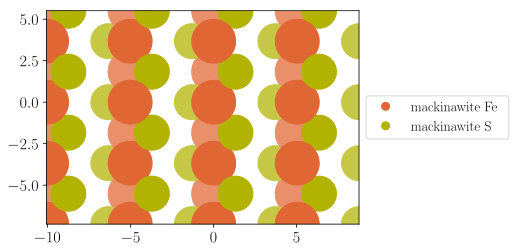

In [14]:
struct = my_data.cif_files.FeS_mackinawite_cif.structure
vstructs = avis.struct_to_visual(struct,'mackinawite')
geomanip = avis.GeometryManipulation()
geomanip.align(vstructs,'c')
geomanip.repeat_cell(vstructs,'a',3)
geomanip.repeat_cell(vstructs,'b',3)
geomanip.repeat_cell(vstructs,'c',3)
geomanip.recentre(vstructs)

avis.plot_atoms_top(vstructs,color_depth=6);

#  Publishing and Distributing Analysis

As discussed above, individual visualisations can be saved individually as images or HTML. But a more complete solution is to use [ipypublish](https://github.com/chrisjsewell/ipypublish) to convert the entire Jupyter Notebook to a document and/or presentation. ipypublish utilises notebook/cell/output level metadata attributes to define a greater level of control as to how elements in the notebook are converted.  

This entire document is a single notebook which is available as a [Notebook](https://github.com/chrisjsewell/chrisjsewell.github.io/blob/master/3d_atomic/3D%20Atomic%20Visualisation.ipynb), [PDF](https://chrisjsewell.github.io/3d_atomic/converted/3D%20Atomic%20Visualisation.view_pdf.html), [HTML](https://chrisjsewell.github.io/3d_atomic/converted/3D%20Atomic%20Visualisation.html) or [Reveal.JS slideshow](https://chrisjsewell.github.io/3d_atomic/converted/3D%20Atomic%20Visualisation.slides.html) document (click the hyperlinks to view them). This was achieved by only the following command line commands: 

```
$ nbpublish -pdf -ptemp -f latex_ipypublish_nocode "3D Atomic Visualisation.ipynb"
$ nbpublish -f html_ipypublish_all "3D Atomic Visualisation.ipynb"
$ nbpresent "3D Atomic Visualisation.ipynb"
```

# TODO

- Orthographic camera. Not yet implemented in ipyvolume, see [this issue](https://github.com/maartenbreddels/ipyvolume/issues/31) for current status.
- better control of spheres
    - exact control of radii (radius rather than scaling size)
    - more segments (either direct control of segments, or a "sphere_hi_res" type)
    - transparency level
    - should color allow (r,g,b) tuple/array?
    because at the moment that doesn't work
- creation of array of arbitrary lines (like scatter but with; x0,y0,z0,x1,y1,z1)
    - show lattice bounding boxes: parallelepiped wire frames 
    - show bonds (i.e. connections) between different scatters
- show nearest-neighbour coordination: polygons with vertices at nearest-neighbour positions (as shown in \cref{fig:nnpolygons})

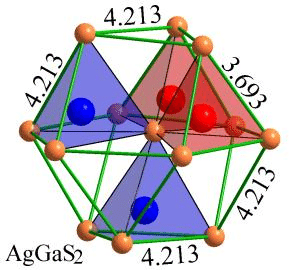

In [42]:
display(Image('data/nn_coordination.jpg',width=200),
        metadata={"ipub":{
      "figure":{
         "caption":"an example of nearest-neighbour polygons",
         "label":"fig:nnpolygons",
         "height":0.2}}})

- functional (browser side) controls, e.g. slider to translate/rotate point set. Not yet implemented in ipywidgets, see [this issue](https://github.com/jupyter-widgets/ipywidgets/issues/1109) for current status.
- volumes:
    - RuntimeWarning: invalid value encountered in true_divide 
    (serialize.py:43) presumably for (0,0,0) gradients
    - rarely get artifact rendering
    - isosurface rendering
    - multiple volumes in single plot
    - volumes with arbitrary centres
    - rotating volumes
- fullscreen
    - fails to open if multiple views instantiated
    - if volume is present,
    then the rendering becomes very low resolution
    and, sometimes, the volume disappears completely on exit
- 2d volume representation
    - define slice into cube and use matplotlib.contour